In [14]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
from globals import glob
import os, re
import pandas as pd
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma
from utilities_analysis import limits_generator, ini_generator_personalized, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability

In [15]:
def mean_calculator(MEAS: pd.DataFrame, lenses_per_nest: int=None) -> pd.DataFrame:
    """Calculate the desired means.
    Parameters:
    - MEAS (pd.DataFrame): Input DataFrame containing fiber measurements.
    - lenses_per_nest (int, optional): Number of lenses per nest for specific means calculation.
    If None, global means are calculated.
    Returns:
    pd.DataFrame: DataFrame containing mean values for fbx and fby.
    If lenses_per_nest is specified, it returns specific means for each position.
    Notes:
    If lenses_per_nest is None:
    - Calculates a global mean for fbx and fby.
    - Returns the mean values for both fbx and fby in a DataFrame.
    - Displays the mean values for fbx and fby.
    If lenses_per_nest is specified:
    - Calculates specific means for each position for fbx and fby based on the number of lenses per nest.
    - Returns a DataFrame containing specific mean values for fbx and fby for each position.
    - Displays the specific mean values for fbx and fby per position."""
    resume = MEAS.transpose().describe() #Transpose the df first due to describe() working in columns.
    rough_means = list(resume.iloc[1, :].values)
    means = []; means_fbx = []; means_fby = [] #Preallocation
    if lenses_per_nest == None: #Calculates a global mean for fbx and for fby
        for i, mean in enumerate(rough_means): #Iterates and rounds every mean value
            means_fbx.append(mean) if i % 2 == 0 else means_fby.append(mean)
            means.append(mean)
        abs_mean_fbx = sum(means_fbx) / len(means_fbx)
        abs_mean_fby = sum(means_fby) / len(means_fby)
        means = [abs_mean_fbx, abs_mean_fby]
        means_df = pd.DataFrame()
        df_list = []
        for _ in range(int(MEAS.shape[0])):  #Iterates over the whole measurements data
            nest_data = []
            for j in range(len(ordered_means)):
                value = float(ordered_means[j])
                nest_data.append(value)
            nest_df = pd.DataFrame({"mean": nest_data})
            df_list.append(nest_df)
        means_df = pd.concat(df_list, axis=0, ignore_index=True)
    else: #Calculates specific means for each position for fbx and fby
        mean_fbx = rough_means[0::2] #Gets fbx values
        mean_fby = rough_means[1::2] #Gets fby values
        for index in range(lenses_per_nest):
            specific_means = mean_fbx[index::lenses_per_nest] #Gets the values of the specific lens for fbx
            abs_mean_fbx = sum(specific_means) / len(specific_means)
            means_fbx.append(abs_mean_fbx)
            specific_means = mean_fby[index::lenses_per_nest] #Gets the values of the specific lens for fby
            abs_mean_fby = sum(specific_means) / len(specific_means)
            means_fby.append(abs_mean_fby)
        means = means_fbx + means_fby
        new_order = [0, 3, 1, 4, 2, 5]
        ordered_means = [means[i] for i in new_order] #Reorder of the means for implementation
        means_df = pd.DataFrame()
        df_list = []
        for _ in range(int(MEAS.shape[0] / (glob.lenses_per_nest * 2))):  #Iterates over every nest (e.g. 24/6=4 nests)
            nest_data = []
            for j in range(len(ordered_means)):
                value = float(ordered_means[j])
                nest_data.append(value)
            nest_df = pd.DataFrame({"mean": nest_data})
            df_list.append(nest_df)
        means_df = pd.concat(df_list, axis=0, ignore_index=True)
    return means_df

def limits_generator(means_df: pd.DataFrame) -> pd.DataFrame:
    """Generate lower and upper tolerance limits based on the means provided in the DataFrame.
    Parameters:
    - means_df (pd.DataFrame): A DataFrame containing a column 'mean' with mean values for each row.
    Returns:
    - pd.DataFrame: A DataFrame with columns 'LO_LIMIT' and 'HI_LIMIT', representing the lower and upper
    tolerance limits calculated based on the mean values. The limits are adjusted depending on the row index:
    - If the index is even, the limits are calculated with x_tolerance.
    - If the index is odd, the limits are calculated with y_tolerance."""
    x_tolerance = glob.x_tolerance
    y_tolerance = glob.y_tolerance
    low_limits = []
    high_limits = []
    for index, row in means_df.iterrows():
        if index % 2 == 0:
            low_limit = row['mean'] - x_tolerance  #Adjusted calculation based on index parity
            high_limit = row['mean'] + x_tolerance
        else:
            low_limit = row['mean'] - y_tolerance
            high_limit = row['mean'] + y_tolerance
        low_limits.append(low_limit)
        high_limits.append(high_limit)
    limits_df = pd.DataFrame({"LO_LIMIT": low_limits, "HI_LIMIT": high_limits})
    return limits_df

def ini_generator_personalized(limits_df: pd.DataFrame) -> None:
    '''Generates a ini file with personalized limits for every mean'''
    class CaseSensitiveConfigParser(configparser.ConfigParser):
        '''A custom class to override optionxform and avoid uppercases being converted to lowercase
        It just works F76 F76 F76 F76 F76'''
        def optionxform(self, optionstr):
            return optionstr
    config = CaseSensitiveConfigParser()
    config.read('../data/template.ini') #Import a template
    keys_list = []
    for section_name in config.sections(): #Get a keys list with the correct uppercased keys
        section = config[section_name]
        keys_list.extend(section.keys())
    HI_LIMIT = limits_df.iloc[:, 1]
    LO_LIMIT = limits_df.iloc[:, 0]
    for section in config.sections(): #Iterate through the sections and options in the .ini file
        keys_list = list(config[section].keys())
        j = 0
        for i in range(0, len(keys_list), 2):
            key1 = keys_list[i]
            key2 = keys_list[i + 1]
            col1 = str(limits_df.iloc[j, 1])
            col2 = str(limits_df.iloc[j, 0])
            j += 1
            config[section][key1] = col1
            config[section][key2] = col2
    for section in config.sections(): #Print the five first elements of the .ini for a quick check
        print(f"[{section}]")
        i = 0
        for key, value in config.items(section): 
            if i < 5:
                print(f"{key} = {value}")
                i += 1
            else:
                break
        print("...")
    with open(f'../a2_output/{glob.tooling}.ini', 'w') as configfile: #Save the modified data to a new .ini file
        for section in config.sections():
            configfile.write(f"[{section}]\n")
            keys = keys_list #Recover the original keys to write them in the .ini file
            for i, key in enumerate(keys):
                configfile.write(f"{key} = {config[section][key]}\n")
                if (i + 1) % 4 == 0 and i < len(keys) - 1: #Insert a blank line every four keys
                    configfile.write("\n")

In [16]:
#File filtering
extension = "xlsx"
file_list = os.listdir("../a1_input/")
filtered_list = [filename for filename in file_list if filename.endswith(extension)]
print("Files ready for storage:")
for file in filtered_list:
    print(f"    {file}")
#pd.read_excel(os.path.join(os.path.abspath("../a1_input"), filtered_list[0]), skiprows = lambda x: x not in specific_rows,)
data = pd.read_excel(os.path.join(os.path.abspath("../a1_input"), filtered_list[0])) #Import the RyR generator output
df = data.iloc[2:, 1:].reset_index(drop=True) #Slices measures and limits
MEAS = reset_df(df.iloc[:, :-2])
LIMITS = reset_df(df.iloc[:, -2:])
df.reset_index(drop=True, inplace=True) #Reset rows index
df.columns = range(df.shape[1]) #Reset columns index

Files ready for storage:
    TOP_PASSAT_B9_2023y-11m-14d_17h-21m-03s.xlsx


In [17]:
means_df = mean_calculator(MEAS, glob.lenses_per_nest)
limits_generator(means_df)

,LO_LIMIT,HI_LIMIT
0,0.313880,0.338880
1,0.334940,0.364940
2,0.318586,0.343586
3,0.343480,0.373480
4,0.326705,0.351705
5,0.351241,0.381241
6,0.313880,0.338880
7,0.334940,0.364940
8,0.318586,0.343586
9,0.343480,0.373480


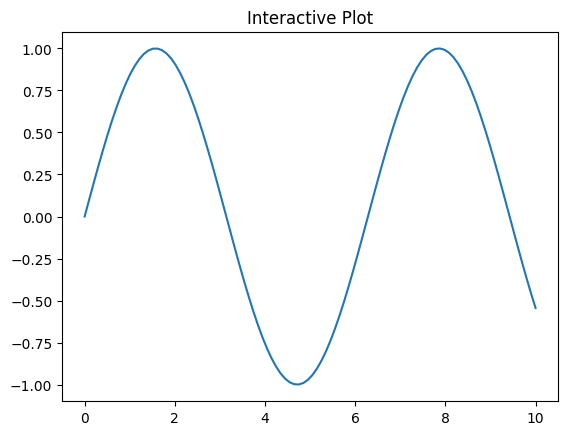

In [3]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create initial plot
fig, ax = plt.subplots()
line, = ax.plot(x, y)
ax.set_title('Interactive Plot')

# Define the update function
def update_plot(a, b):
    updated_y = np.sin(a * x + b)
    line.set_ydata(updated_y)
    fig.canvas.draw_idle()

# Create widgets
a_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='A:')
b_slider = widgets.FloatSlider(value=0.0, min=0.0, max=2*np.pi, step=0.1, description='B:')

# Create an interactive output
output = widgets.interactive_output(update_plot, {'a': a_slider, 'b': b_slider})

# Display widgets and output
display(widgets.VBox([a_slider, b_slider, output]))
